

# Datasets, evaluation and fine-tuning.

## Dataset

In **deep**doctection, there is a module `datasets` available that allows you to use some public datasets straight away. They might also help you by providing examples if you want to make you custom dataset ready for **deep**doctection.

In [1]:
import deepdoctection as dd

from matplotlib import pyplot as plt

Let's print a list of all built-in datasets. 

In [ ]:
dd.print_dataset_infos(add_license=False, add_info=False)

With `get_dataset("doclaynet")` we can create an instance of a built-in dataset.

In [3]:
doclaynet = dd.get_dataset("doclaynet")

print(doclaynet.dataset_info.description)

DocLayNet is a human-annotated document layout segmentation dataset containing 80863 pages from a broad variety of document sources. 
DocLayNet provides page-by-page layout segmentation ground-truth using bounding-boxes for 11 distinct class labels on 80863 unique pages from 6 document categories. It provides several unique features compared to related work such as PubLayNet or DocBank: 
Humman Annotation: DocLayNet is hand-annotated by well-trained experts, providing a gold-standard in layout segmentation through human recognition and interpretation of each page layout 
Large layout variability: DocLayNet includes diverse and complex layouts from a large variety of public sources in Finance, Science, Patents, Tenders, Law texts and Manuals 
Detailed label set: DocLayNet defines 11 class labels to distinguish layout features in high detail. 
Redundant annotations: A fraction of the pages in DocLayNet are double- or triple-annotated, allowing to estimate annotation uncertainty and an up

In **deep**doctection there is no function that automatically downloads a dataset from its remote storage. You have to download and unpack it by yourself. Note further, that all datasets are image datasets and in most cases quite large. 

To install the dataset, go to the url below and download the zip-file. 

In [4]:
doclaynet.dataset_info.url

'https://codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud/dax-doclaynet/1.0.0/DocLayNet_core.zip'

You will have to unzip and place the data set in your local **.cache/deepdoctection/dataset** directory. Once extracted, the dataset will already have the expected folder structure. If you are unsure, however, you can get some additional information about the physical structure by calling the dataset module docstring:

In [ ]:
doclaynet.dataflow.get_workdir()

In [6]:
print(dd.datasets.instances.doclaynet.__doc__)


Module for DocLayNet dataset. Place the dataset as follows

|    DocLayNet_core
|    ├── COCO
|    │ ├── test.json
|    │ ├── val.json
|    ├── PNG
|    │ ├── 0a0d43e301facee9e99cc33b9b16e732dd207135f4027e75f6aea2bf117535a2.png



## Dataflow

If you know iterable-style datasets in PyTorch you will see that in **deep**doctection samples will be generated in the same fashion. The API differs, though: We will now use the `datasets.dataflow.build` method to display some data points. 

Samples produced by `datasets.dataflow.build` are already in **deep**doctection's data format. 

In [7]:
df = doclaynet.dataflow.build(split="train") # get the dataflow generator
df.reset_state() # an intrinsic dataflow method that must always be called before streaming data. You will get an 
                 # error if you forget to do this.

df_iter = iter(df) 

datapoint = next(df_iter)

datapoint_dict = datapoint.as_dict() # displaying the Image class is very messy

datapoint_dict["file_name"],datapoint_dict["_image_id"], datapoint_dict["annotations"][0]

[1113 11:20.30 @context.py:131]  INF  Loading annotations to memory total: 8.0292 sec.
[1113 11:20.31 @context.py:131]  INF  creating index total: 0.5403 sec.
100%|##################################################################################################################################################################################|69375/69375[00:00<00:00,1548308.66it/s]
[1113 11:20.31 @context.py:131]  INF  Start loading .json file and serializing total: 8.6277 sec.


('c6effb847ae7e4a80431696984fa90c98bb08c266481b9a03842422459c43bdd.png',
 '4385125b-dd1e-3025-880f-3311517cc8d5',
 {'active': True,
  'external_id': 0,
  '_annotation_id': '4385125b-dd1e-3025-880f-3311517cc8d5',
  'category_name': <LayoutType.page_header>,
  '_category_name': <LayoutType.page_header>,
  'category_id': '6',
  'score': None,
  'sub_categories': {<DatasetType.publaynet>: {'active': True,
    'external_id': None,
    '_annotation_id': 'f99838b9-6fdc-3e96-b500-cc857b28b564',
    'category_name': <LayoutType.title>,
    '_category_name': <LayoutType.title>,
    'category_id': '11',
    'score': None,
    'sub_categories': {},
    'relationships': {}}},
  'relationships': {},
  'bounding_box': {'absolute_coords': True,
   'ulx': 72.35294285130719,
   'uly': 55.47565740740731,
   'lrx': 444.5686274509804,
   'lry': 75.92855715197959},
  'image': None})

Depending on the data set, different configurations of the `build` method can yield different representations of data points. For example, the underlying image is not loaded by default. By passing the parameter `load_image=True` the image will be loaded.

Note, that all images in **deepdoctection** are loaded using the OpenCV framework, where the default loading setting is BGR. Matplotlib (and PIL default-setting) expects a numpy array in RGB order, which is why we have to swap dimensions. 

[1113 11:20.41 @context.py:131]  INF  Loading annotations to memory total: 9.7734 sec.
[1113 11:20.41 @context.py:131]  INF  creating index total: 0.5317 sec.
100%|###################################################################################################################################################################################|69375/69375[00:00<00:00,740000.00it/s]
[1113 11:20.41 @context.py:131]  INF  Start loading .json file and serializing total: 10.4106 sec.


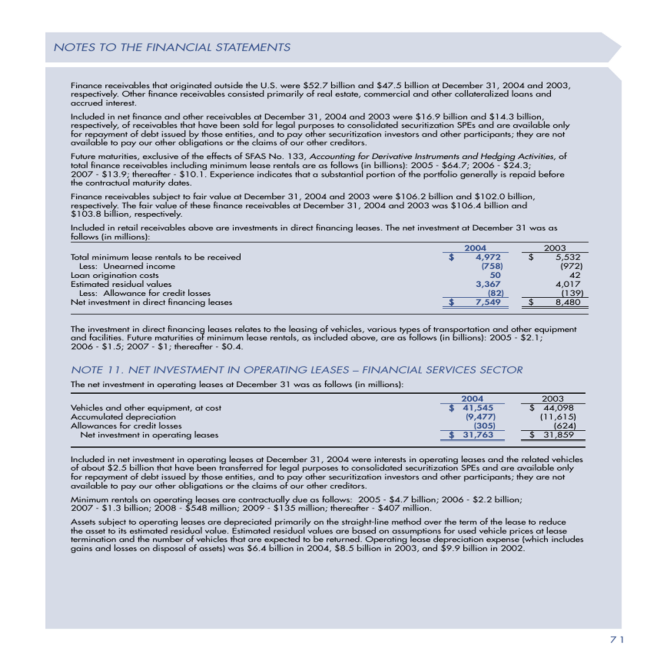

In [8]:
df = doclaynet.dataflow.build(split="train",load_image=True)
df.reset_state()

df_iter = iter(df)
datapoint = next(df_iter)

plt.figure(figsize = (15,12))
plt.axis('off')
plt.imshow(datapoint.image[:,:,::-1])

## Custom dataset

If you bring your own dataset, there is a client-class `CustomDataset` with a simple interface. Please check the docs to get some help, if you want to build a custom dataset. 

## Evaluation

In many situation you are not interested in raw predictions of a model but on results which have been polished through several post-processing steps. In other situations, you want to measure accuracy/precision etc. not after running one but several models. For example, getting the html representation of a table requires output from several predictors. Evaluating along a pipeline allows you to see how model prediction(s) and post processing works in conjunction. 

**deep**doctection comes equipped with an evaluator that allows you to run evaluation not on a model directly but on a pipeline component or a full pipeline.   

Let's take the layout detection model. It has been trained on `Publaynet`, a dataset of images from medical research papers. We will check, how it will perform on `Doclaynet`.  

First we need to set up a pipeline backbone. 

In [ ]:
config_yaml_path = dd.ModelCatalog.get_full_path_configs("layout/d2_model_0829999_layout_inf_only.pt")
weights_path = dd.ModelCatalog.get_full_path_weights("layout/d2_model_0829999_layout_inf_only.pt")
categories = dd.ModelCatalog.get_profile("layout/d2_model_0829999_layout_inf_only.pt").categories
layout_detector = dd.D2FrcnnDetector(config_yaml_path,weights_path,categories)
layout_service = dd.ImageLayoutService(layout_detector)

Next, we need a metric.

In [10]:
coco_metric = dd.get_metric("coco")

Now the dataset. Doclaynet has several other labels but there is a mapping that collapses all doclaynet labels into publaynet labels. Let's see how to invoke this mapping. Datasets have a categories object:

In [11]:
doclaynet.dataflow.categories.get_categories()

{'1': <LayoutType.caption>,
 '2': <LayoutType.footnote>,
 '3': <LayoutType.formula>,
 '4': <LayoutType.list>,
 '5': <LayoutType.page_footer>,
 '6': <LayoutType.page_header>,
 '7': <LayoutType.figure>,
 '8': <LayoutType.section_header>,
 '9': <LayoutType.table>,
 '10': <LayoutType.text>,
 '11': <LayoutType.title>}

In [12]:
cat_to_sub_cat = doclaynet.dataflow.categories.get_sub_categories()
cat_to_sub_cat = {key:val[0] for key, val in cat_to_sub_cat.items()}
cat_to_sub_cat

{<LayoutType.caption>: <DatasetType.publaynet>,
 <LayoutType.footnote>: <DatasetType.publaynet>,
 <LayoutType.formula>: <DatasetType.publaynet>,
 <LayoutType.list>: <DatasetType.publaynet>,
 <LayoutType.page_footer>: <DatasetType.publaynet>,
 <LayoutType.page_header>: <DatasetType.publaynet>,
 <LayoutType.figure>: <DatasetType.publaynet>,
 <LayoutType.section_header>: <DatasetType.publaynet>,
 <LayoutType.table>: <DatasetType.publaynet>,
 <LayoutType.text>: <DatasetType.publaynet>,
 <LayoutType.title>: <DatasetType.publaynet>}

The sub category `publaynet` provides the mapping into `publaynet` labels. Let's use them.

In [13]:
doclaynet.dataflow.categories.set_cat_to_sub_cat(cat_to_sub_cat)

Now, that dataset, pipeline component and metric has been setup, we can build the evaluator.

In [ ]:
evaluator = dd.Evaluator(doclaynet,layout_service, coco_metric)

We start evaluation using the `run` method. `max_datapoints` limits the number of samples to at most 100 samples. The `val` split is used by default.

In [ ]:
evaluator = dd.Evaluator(doclaynet,layout_service, coco_metric)
output= evaluator.run(max_datapoints=100)

The result shows that Doclaynet has a very different layout compared to Publaynet where the model has been trained on. To get a feeling, results on the Publaynet test split are in the range of 0.9+ !

In [16]:
import tabulate

header = output[0].keys()
rows =  [x.values() for x in output]
print(tabulate.tabulate(rows, header))

  ap  iouThr    areaRng      maxDets  mode           val
----  --------  ---------  ---------  ------  ----------
   1            all              100  bbox    0.146866
   1  0.5       all              100  bbox    0.195206
   1  0.75      all              100  bbox    0.143785
   1            small            100  bbox    0.00988449
   1            medium           100  bbox    0.0219617
   1            large            100  bbox    0.199535
   0            all                1  bbox    0.100273
   0            all               10  bbox    0.170546
   0            all              100  bbox    0.173715
   0            small            100  bbox    0.0092514
   0            medium           100  bbox    0.0306123
   0            large            100  bbox    0.231041


## Fine tuning

You can fine-tune most models to improve accuracy/precision/recall on your data. There are some training scripts available that you can use straight away. The configuration below gives you a decent fine tuning training schedule. For more information about the config, check the docs of Detectron2. 

In [17]:
config_overwrite=["SOLVER.MAX_ITER=100000",    # Tensorpack equivalent:  TRAIN.LR_SCHEDULE=[100000]
                  "TEST.EVAL_PERIOD=20000",                           #  TRAIN.EVAL_PERIOD=40 (run a 500 samples * 40) 
                  "SOLVER.CHECKPOINT_PERIOD=20000",                   #  TRAIN.CHECKPOINT_PERIOD=40
                  "MODEL.BACKBONE.FREEZE_AT=0",                       #  BACKBONE.FREEZE_AT=0 (train the every layer of the backbone and do not freeze the bottom layers)
                  "SOLVER.BASE_LR=1e-3"]                              #  TRAIN.BASE_LR=1e-3

build_train_config = ["max_datapoints=86000"]  # you can also change the setting if you want to train with less samples

In [ ]:
dd.train_d2_faster_rcnn(path_config_yaml=config_yaml_path,
                  dataset_train= doclaynet,
                  path_weights=weights_path,
                  config_overwrite=config_overwrite,
                  log_dir="/home/janis/Tests/test_doclaynet",
                  build_train_config=build_train_config,
                  dataset_val=doclaynet,
                  build_val_config=None,
                  metric=coco_metric,
                  pipeline_component_name="ImageLayoutService"
                 )

If you fine tune the model with this setting you can increase mAP/mAR to a region of 0.75.  